In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/divyaKh/CMPE255Project/main/2.Data_Cleaning/cleaned_dataset_label_encoding.csv')

In [50]:
y = dataset['label']
x = dataset.drop(['label'],axis=1)
x = x.drop(['attack_cat'],axis=1)
column_list = list(x)
print("Shape of x: ", x.shape)
print("Shape of y: ", y.shape)

Shape of x:  (257673, 42)
Shape of y:  (257673,)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [44]:
from sklearn.tree import DecisionTreeClassifier

In [75]:
model = DecisionTreeClassifier(criterion='gini' ,max_depth=3, random_state = 0)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [76]:
model.score(X_test, y_test)

0.8911153657085198

In [77]:
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     27947
           1       0.94      0.89      0.91     49355

    accuracy                           0.89     77302
   macro avg       0.88      0.89      0.88     77302
weighted avg       0.90      0.89      0.89     77302



In [78]:
from sklearn.tree import export_graphviz

In [83]:
export_graphviz(model, out_file = 'images/decisionTree.dot', feature_names=column_list )

run `dot -Tpng images/decisionTree.dot -o images/decisionTree.png` to generate png for the tree.

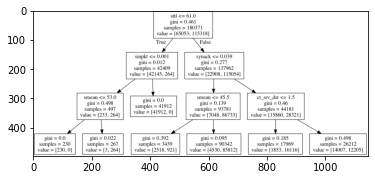

In [84]:
import matplotlib.image as mpimg
img = mpimg.imread('images/decisionTree.png')
plt.imshow(img)
plt.show()